####ALL IMPORTS

In [27]:
%ls

Archive/
Archive.zip
Euro sat - Resnet 30 epochs without weights Transfer Learning.ipynb
Euro sat - Resnet 30 epochs without weights- Transfer Learning with 13 bands.ipynb
Euro sat - Resnet 30 epochs without weights.ipynb
Euro_sat_VGG.ipynb
PLANET_IMAGE_CLASSIFICATION RESNET.ipynb
PLANET_IMAGE_CLASSIFICATION-DENSENET121.ipynb
PLANET_IMAGE_CLASSIFICATION-VGG16.ipynb
PlanetDataset/
Transfer_Learning_Satellite_Classification_using_RESNET.ipynb
densenet.pth
resnet.pth
train_results.pkl
train_results_densnet.pkl


In [78]:
import os
import random
from time import time
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
import dill as pickle
from plotly import graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
# from torchsummary import summary


import torch; 
torch.backends.mps.is_available()

True

In [79]:
d = "cpu"
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    d = "mps"
elif torch.cuda.is_available():
    d = "cuda:0"
device = torch.device(d)

print("Device: {}".format(device))

Device: mps


In [80]:
path = "./PlanetDataset/"
path_train = os.path.join(path, "train-jpg")
path_test = os.path.join(path, "test-jpg")
print(
    f"train files: {len(os.listdir(path_train))}, "
    f"test files: {len(os.listdir(path_test))}"
)

train files: 40479, test files: 40669


In [81]:
path_class = os.path.join(path, "train_v2.csv")
df_class = pd.read_csv(path_class)
print(df_class.shape)
df_class.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [82]:
df_class["list_tags"] = df_class.tags.str.split(" ")
classes = df_class.list_tags.values
tags = [tag for row in classes for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame(
    {"Class": counter_tags.keys(), "Frequency": counter_tags.values()}
).sort_values("Frequency")

fig = px.bar(df_tags, x="Class", y="Frequency", orientation="v", 
             color="Frequency",color_continuous_scale=["red", "yellow",
                                         "green", "blue"]
)
fig.update_layout(title="Class distribution")
fig.show()

In [83]:
df_tags

,Class,Frequency
11,conventional_mine,100
16,blow_down,101
8,slash_burn,209
14,blooming,332
13,artisinal_mine,339
15,selective_logging,340
12,bare_ground,862
9,cloudy,2089
0,haze,2697
5,habitation,3660


In [84]:
RARE_CLASSES = [
    "bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"
]

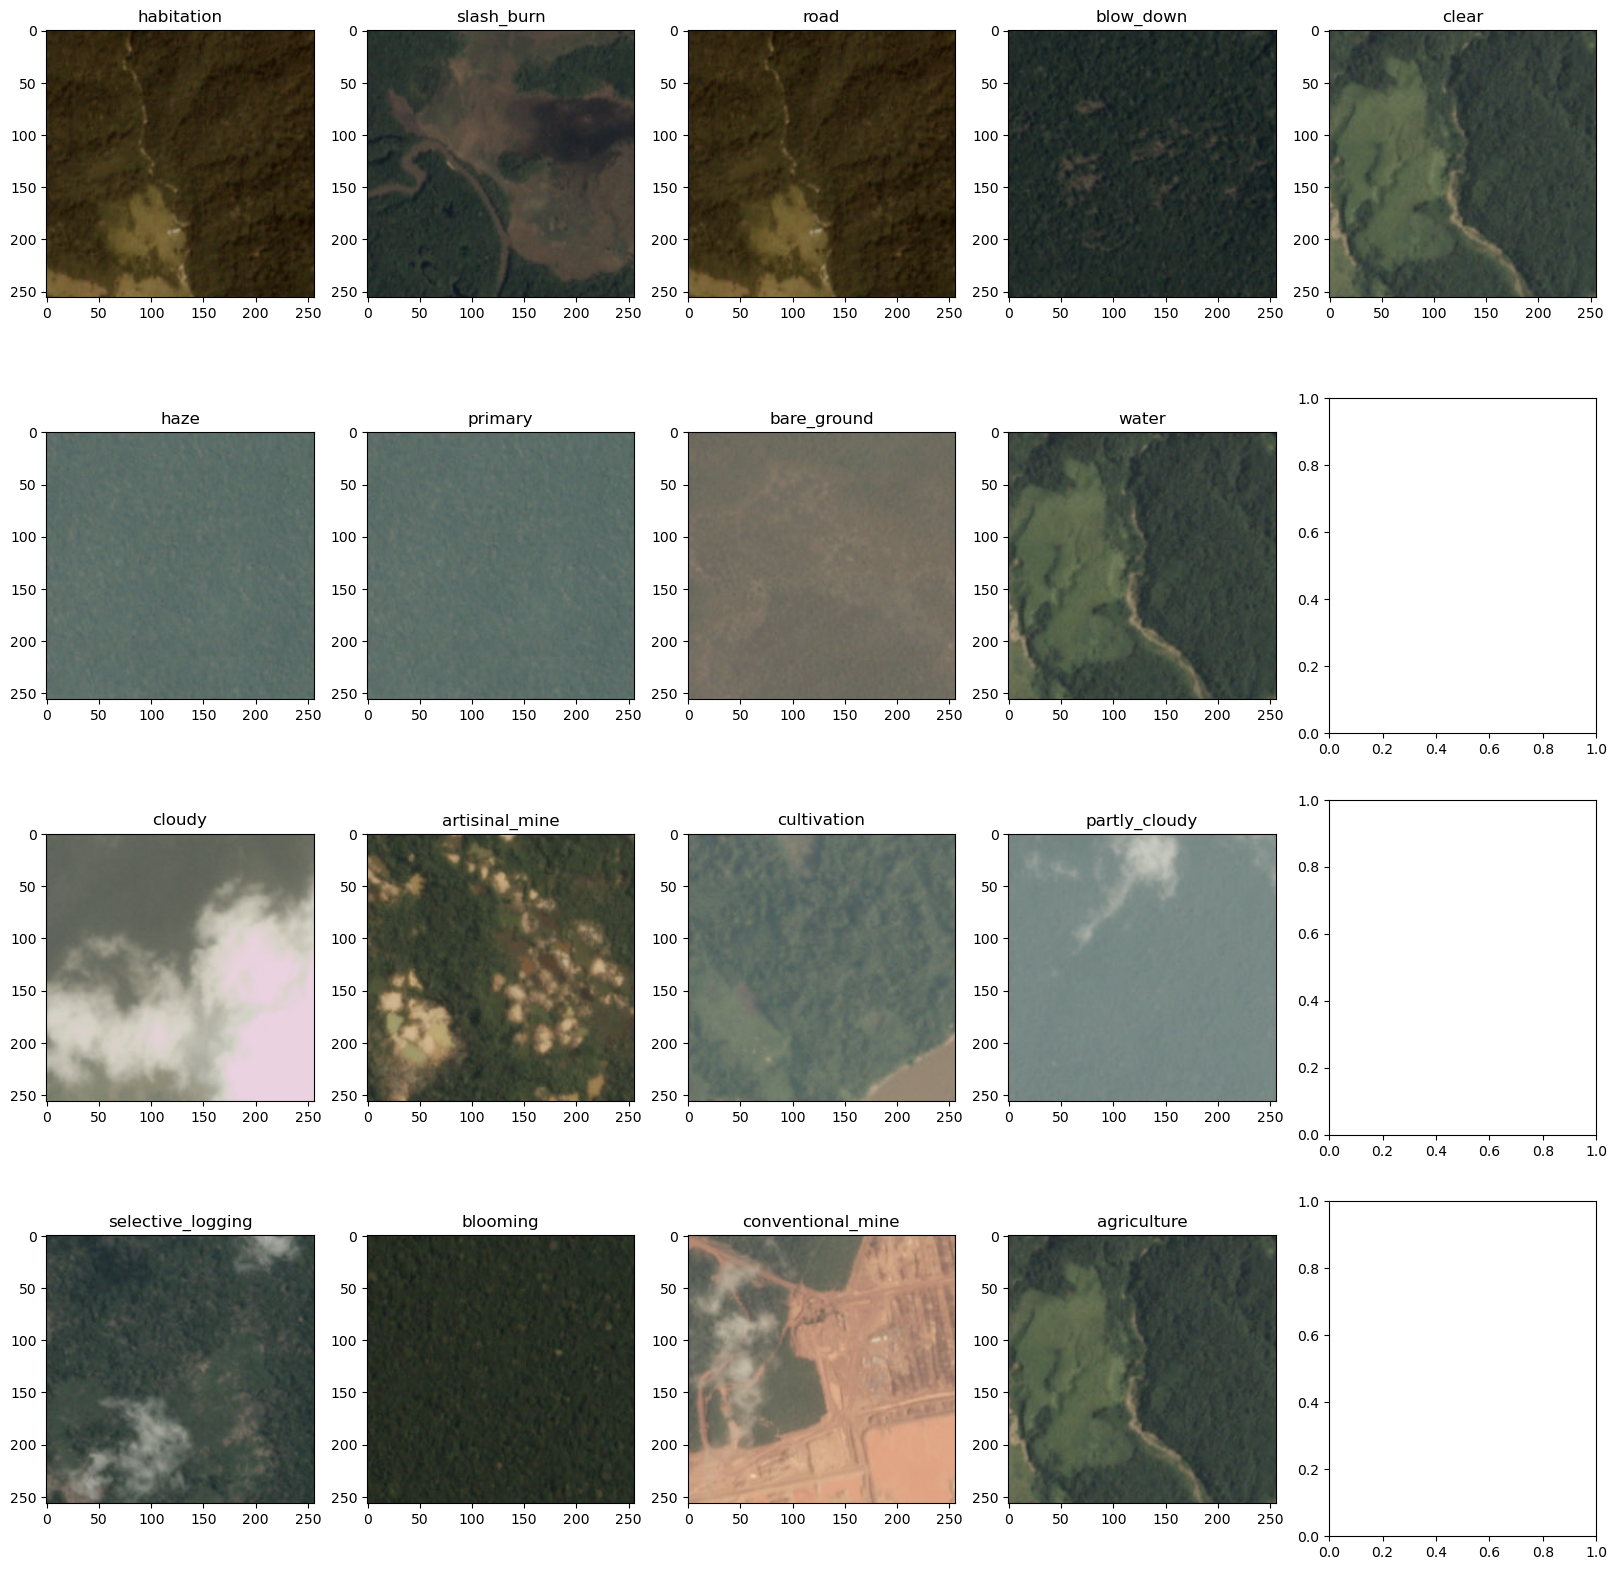

In [85]:
all_tags = list(set(tags))
N_tags = len(all_tags)
fig, axes = plt.subplots(4, 5, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = df_class.loc[df_class.tags.str.contains(tag)].image_name.values[0]
    img = cv2.imread(os.path.join(path_train, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)


In [86]:
def get_transforms():
    transform_train = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225],
      ),
      T.RandomRotation((90,180)),
      T.RandomVerticalFlip(p=0.5),
      T.RandomHorizontalFlip(p=0.5)
        
    ])
    transform_val = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
      ),
      T.RandomRotation((90,180)),
      T.RandomVerticalFlip(p=0.5),
      T.RandomHorizontalFlip(p=0.5)
    ])
    return transform_train, transform_val

In [87]:
class CustomDatasetError(Exception):
    pass


class CustomDataset(Dataset):
    def __init__(self, df, labels, transform, path, is_train=True, idx_tta=None):
        super().__init__()
        self.df = df
        self.labels = labels
        self.transform = transform
        if isinstance(path, str):
            self.paths = [path]
        elif isinstance(path, (list, tuple)):
            self.paths = path
        else:
            raise CustomDatasetError(f"Path type must be str, list or tuple, got: {type(path)}")
        self.is_train = is_train
        if not is_train:
            if not idx_tta in list(range(6)):
                raise CustomDatasetError(
                    f"In test mode, 'idx_tta' must be an int belonging to [0, 5], got: {repr(idx_tta)}"
                )
            self.idx_tta = idx_tta

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        for path in self.paths:
            if filename in os.listdir(path):
                file_path = os.path.join(path, filename)
                break
        else:
            raise CustomDatasetError(f"Can't fetch {filename} among {self.paths}")
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        return img, label

    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
            img = torch.tensor(img)
            img = img.permute(2, 0, 1)
            img = self.transform(img)
            imgs.append(img[None])
            labels.append(label)
        imgs = torch.cat(imgs).float().to(device)
        labels = torch.tensor(labels).float().to(device)
        return imgs, labels

    def load_img(self, idx, ax=None):
        img, labels = self[idx]
        label = self.df.iloc[idx].tags
        title = f"{label} - {labels}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)
    
   

In [88]:
def get_data(df_train, df_val):
    encoder = MultiLabelBinarizer()
    tags_train = encoder.fit_transform(df_train.list_tags.values)
    tags_val = encoder.transform(df_val.list_tags.values)

    transform_train, transform_val = get_transforms()
    ds_train = CustomDataset(df_train, tags_train, transform_train, path=path_train)
    ds_val = CustomDataset(df_val, tags_val, transform_val, path=path_train)

    dl_train = DataLoader(
      ds_train,
      batch_size=32,
      shuffle=True,
      collate_fn=ds_train.collate_fn
    )
    dl_val = DataLoader(
      ds_val,
      batch_size=32,
      shuffle=True,
      collate_fn=ds_val.collate_fn
    )

    return ds_train, ds_val, dl_train, dl_val, encoder

In [89]:
df_train, df_val = train_test_split(df_class, test_size=.2)



In [90]:
df_class=df_class[0:10000]

In [91]:
df_train, df_val = train_test_split(df_class, test_size=.2)

ds_train, ds_val, dl_train, dl_val, encoder = get_data(df_train, df_val)

# imgs, labels = next(iter(dl_train))
# imgs.shape, labels.shape

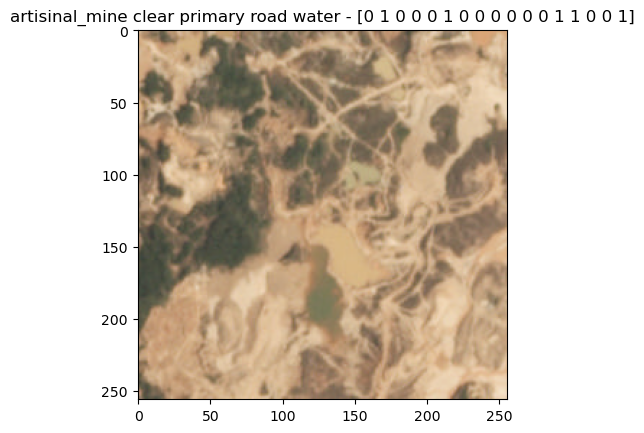

In [92]:
ds_train.load_img(1)

In [93]:
for class_, idx in encoder._cached_dict.items():
    print(class_)

agriculture
artisinal_mine
bare_ground
blooming
blow_down
clear
cloudy
conventional_mine
cultivation
habitation
haze
partly_cloudy
primary
road
selective_logging
slash_burn
water


In [94]:

def get_model():
    model = models.vgg16(weights=False)
    print(model)
    model.classifier[-1] = nn.Linear(in_features=4096, out_features=17)
    model.classifier.add_module('sigmoid', nn.Sigmoid())
    model.classifier.named_parameters
    optimizer = Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.BCELoss()

    return model.to(device), optimizer, loss_fn

In [95]:
model,optimizer,loss_fn=get_model()

/Users/priyangpatel/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [98]:
for rare_class in RARE_CLASSES:
    total_train = df_train.loc[df_train.tags.str.contains(rare_class)].shape[0]
    total_val = df_val.loc[df_val.tags.str.contains(rare_class)].shape[0]
    print(f"train {rare_class}: {100 * total_train / df_train.shape[0]:.4f}% ({total_train})")
    print(f"val {rare_class}: {100 * total_val / df_val.shape[0]:.4f}% ({total_val})\n")

train bare_ground: 2.0000% (160)
val bare_ground: 2.0000% (40)

train selective_logging: 0.8750% (70)
val selective_logging: 0.6000% (12)

train artisinal_mine: 0.8750% (70)
val artisinal_mine: 0.9000% (18)

train blooming: 0.8250% (66)
val blooming: 0.8000% (16)

train slash_burn: 0.5500% (44)
val slash_burn: 0.3500% (7)

train blow_down: 0.3750% (30)
val blow_down: 0.1500% (3)

train conventional_mine: 0.1750% (14)
val conventional_mine: 0.0500% (1)



In [99]:
len(dl_train)

250

In [100]:
def train_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_predicted = model(X)
    batch_loss = loss_fn(Y_predicted, Y)
    batch_loss.backward()
    optimizer.step()
    Y_predicted = Y_predicted.cpu().detach().numpy()
    
    return Y_predicted, batch_loss.item()


def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_predicted = model(X)
    batch_loss = loss_fn(Y_predicted, Y)
    Y_predicted = Y_predicted.cpu().detach().numpy()
    return Y_predicted, batch_loss.item()

In [101]:
def class_acc(n_correct,n_samples,n_class_correct,n_class_samples):
    for i in range(17):
      print("-------------------------------------------------")
      acc = 100.0 * n_correct[i] / n_samples
      print(f'Overall class performance: {round(acc,1)} %')
      for k in range(17):
          acc = 100.0 * n_class_correct[i][k] / n_class_samples[i][k]
          print(f'Accuracy of class{i}/{k}: {round(acc,1)} %')
    print("-------------------------------------------------")

In [102]:
def calculate_average_accuracy(Y_train_epoch, Y_thresh_train_epoch):
      correctly_classified_samples=0
      total_number_of_samples=0
      for i in range(len(Y_train_epoch)):
        for class_, k in encoder._cached_dict.items():
            LY=Y_train_epoch[i][k]
            PY=Y_thresh_train_epoch[i][k]
            if(LY==PY):
              correctly_classified_samples+=1
            total_number_of_samples+=1
      
      return float(100*(correctly_classified_samples/total_number_of_samples))
            



In [103]:
# statistics={"agriculture":{"loss":0,"accuracy":},
# "artisinal_mine":{"loss":0,"accuracy":},
# "bare_ground":{"loss":0,"accuracy":},
# "blooming":{"loss":0,"accuracy":},
# "blow_down":{"loss":0,"accuracy":},
# "clear":{"loss":0,"accuracy":},
# "cloudy":{"loss":0,"accuracy":},
# "conventional_mine":{"loss":0,"accuracy":},
# "cultivation":{"loss":0,"accuracy":},
# "habitation":{"loss":0,"accuracy":},
# "haze":{"loss":0,"accuracy":},
# "partly_cloudy":{"loss":0,"accuracy":},
# "primary":{"loss":0,"accuracy":},
# "road":{"loss":0,"accuracy":},
# "selective_logging":{"loss":0,"accuracy":},
# "slash_burn":{"loss":0,"accuracy":},
# "water":{"loss":0,"accuracy":},}



num_epochs = 10
total_steps = len(dl_train)
# t1 = time.time()
model,optimizer,loss_fn=get_model()
loss_train, loss_val = [], []
accuracy_train, accuracy_val = [], []
Y_predicted_val = None
best_loss_val = np.inf
for epoch in range(num_epochs):

    loss_train_epoch, loss_val_epoch = [], []
    Y_predicted_train_epoch, Y_predicted_val_epoch = [], []
    Y_train_epoch, Y_val_epoch = [], []

    for j, data in enumerate(dl_train):
        
        print("batch:"+str(j))
        images = data[0].to(device)
        outputs = model(images)
        labels =data[1].to(device)
        Y_predicted, batch_loss=train_batch(images,labels,model,loss_fn,optimizer)
        loss_train_epoch.append(batch_loss)
        Y_predicted_train_epoch.extend(Y_predicted)
        Y_train_epoch.extend(labels.detach().float().cpu().numpy())
        
        

    for j, data in enumerate(dl_val):
        images = data[0].to(device)
        outputs = model(images)
        labels =data[1].to(device)
        Y_predicted, batch_loss = compute_val_loss(images,labels,model,loss_fn)
        loss_val_epoch.append(batch_loss)
        Y_predicted_val_epoch.extend(Y_predicted)
        Y_val_epoch.extend(labels.detach().float().cpu().numpy())




    avg_loss_train = np.mean(loss_train_epoch)
    avg_loss_val = np.mean(loss_val_epoch)
    Y_predicted_train_epoch = np.array(Y_predicted_train_epoch)
    Y_predicted_val_epoch = np.array(Y_predicted_val_epoch)
    Y_thresh_train_epoch = (Y_predicted_train_epoch > .2).astype(float)
    Y_thresh_val_epoch = (Y_predicted_val_epoch > .2).astype(float)
    Y_train_epoch = np.array(Y_train_epoch)
    Y_val_epoch = np.array(Y_val_epoch)

    accuracy_train_epoch = calculate_average_accuracy(Y_train_epoch, Y_thresh_train_epoch)
    accuracy_val_epoch = calculate_average_accuracy(Y_val_epoch, Y_thresh_val_epoch)

    # saving values for debugging
    if avg_loss_val < best_loss_val:
        best_loss_val = avg_loss_val
        Y_predicted_val = Y_predicted_val_epoch
        Y_thresh_val = Y_thresh_val_epoch
        Y_val = Y_val_epoch
            
    loss_train.append(avg_loss_train)
    loss_val.append(avg_loss_val)
    accuracy_train.append(accuracy_train_epoch)
    accuracy_val.append(accuracy_val_epoch)
    
    print(
            f"epoch: {epoch}/{num_epochs} -- train loss: {avg_loss_train}, " \
            f"val loss: {avg_loss_val}" \
            f" -- train Accuracy: {accuracy_train_epoch}, " \
            f"val Accuracy: {accuracy_val_epoch}"
    )

train_results = {
        "loss_train": loss_train,
        "loss_val": loss_val,
        "accuracy_train": accuracy_train,
        "accuracy_val": accuracy_val,
        "Y_predicted_val": Y_predicted_val,
        "Y_thresh_val": Y_thresh_val,
        "Y_val": Y_val,
    }

torch.save(model, f"vgg.pth")
pickle.dump(train_results, open(f"train_results_vgg.pkl", "wb"))
 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

KeyboardInterrupt: 

In [ ]:
%ls

In [ ]:
model = torch.load("./vgg.pth")
train_results = pickle.load(open("train_results_vgg.pkl", "rb"))

In [ ]:
loss_train = train_results["loss_train"]
loss_val = train_results["loss_val"]
accuracy_train = train_results["accuracy_train"]
accuracy_val = train_results["accuracy_val"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Fbeta scores"))
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_train))),
        y=loss_train,
        name="loss_train",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_val))),
        y=loss_val,
        name="loss_val",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(accuracy_train))),
        y=accuracy_train,
        name="accuracy_train",
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(accuracy_val))),
        y=accuracy_val,
        name="accuracy_val",
    ),
    row=1, col=2
)
fig.show()

In [ ]:
Y_predicted_val = np.array(train_results["Y_predicted_val"])
Y_val = np.array(train_results["Y_val"])

pos_probas, neg_probas = [], []
for class_, idx in encoder._cached_dict.items():
    pos_probas.append(Y_predicted_val[np.where(Y_val[:, idx] != 0), idx].mean())
    neg_probas.append(Y_predicted_val[np.where(Y_val[:, idx] == 0), idx].mean())
go.Figure([
    go.Bar(x=list(encoder._cached_dict), y=pos_probas, name="Y_predicted proba | Y = 1"),
    go.Bar(x=list(encoder._cached_dict), y=neg_probas, name="Y_predicted proba | Y = 0")
]).show()

In [ ]:
def find_best_thresholds(Y_predicted, Y):
    N_tags = Y.shape[1]
    best_threshs = [0.2] * N_tags
    resolution = 100
    for jdx in range(N_tags):
        best_score = 0
        #threshs = np.zeros_like(best_threshs)
        threshs = best_threshs.copy()
        for kdx in range(resolution):
            kdx /= resolution
            threshs[jdx] = kdx
            Y_predicted_thresh = (Y_predicted > threshs).astype(float)
            score = calculate_average_accuracy(Y, Y_predicted_thresh)
            if score > best_score:
                best_score = score
                best_threshs[jdx] = kdx
    
    global_best_score = calculate_average_accuracy(Y, (Y_predicted > best_threshs).astype(float))
    print(f"threshs: {best_threshs} -- best score: {global_best_score}")
    
    return best_threshs

In [ ]:
threshs = find_best_thresholds(Y_predicted_val, Y_val)


In [ ]:
class_scores = {}
classes = encoder.classes_
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_predicted_val = (Y_predicted_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    score = fbeta_score(y_val, y_predicted_val, beta=2)
    class_scores[classes[jdx]] = round(score, 4)

df_score = pd.DataFrame(dict(
    label=list(class_scores.keys()), score=list(class_scores.values()),
)).sort_values("score", ascending=False)
fig = px.bar(df_score, x="label", y="score", color="score")
fig.show()

In [ ]:
fig = make_subplots(cols=5, rows=4)
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_predicted_val = (Y_predicted_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    tn, fp, fn, tp = confusion_matrix(y_val, y_predicted_val).ravel()
    mat = np.array([[fn, tn], [tp, fp]])
    col = jdx // 4+1
    row = jdx % 4+1
    fig.add_trace(
        go.Heatmap(
            z=mat, text=[[f"fn: {fn}", f"tn: {tn}"], [f"tp: {tp}", f"fp: {fp}"]], 
            texttemplate="%{text}", colorscale='Viridis', name=encoder.classes_[jdx],
            showscale=False
        ),
        col=col, row=row, 
    )
    fig.update_xaxes(title=encoder.classes_[jdx], showticklabels=False, row=row, col=col)
    fig.update_yaxes(showticklabels=False, row=row, col=col)
    

fig.update_layout(
    width=1200, height=800, title="Confusion matrices", 
)
fig.show()